# PAML for dynamic systems:
### Neural ODE and training methods for continuous-time models
Example system: Nonlinear spring pendulum

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Author: Fabian J. Roth

---

#### In this notebook, you will...

* <span style="color:red">learn something... Todo.</span>

In [1]:
def is_colab():
    """Determine if the code is running in Google Colab."""
    try:
        import google.colab

        return True
    except ImportError:
        return False


if is_colab():
    print("Running in Google Colab, trying to install LecturePhysicsAwareML...")
    !git clone --depth 1 https://github.com/Drenderer/LecturePhysicsAwareML.git
    %cd LecturePhysicsAwareML/dynamic_modeling
    %pip install -e .
    print(
        "Make sure to restert the session after installation (Runtime > Restart Session)."
    )
else:
    print(
        "Not running in Google Colab. \nPlease install the package manually if needed. If you are using pip, run:\n>>> pip install -e .\nin the dynamic_modeling directory."
    )

Not running in Google Colab. 
Please install the package manually if needed. If you are using pip, run:
>>> pip install -e .
in the dynamic_modeling directory.


## 1. The spring pendulum system
In this task we consider a nonlinear spring pendulum system:

<img src="images\Spring_pendulum_only_cartesian.png" height="400"/>

The governing equations can be obtained by using Hamiltons Principle and the Euler---Lagrange equations.

Describing position of the mass $m$ with generalized (cartesian) coordinates $q_x, q_y$ and their velocities $\dot q_x, \dot q_y$, the total kinetic energy $T$ and potential energy $U$ are given by
$$
\begin{align}
    T = \frac{1}{2}m \dot q_x^2 + \frac{1}{2}m \dot q_y^2, && U = \frac{1}{2}k\big(\sqrt{q_x^2+q_y^2} - l_0\big)^2 + mgq_y.
\end{align}
$$

where $k$, $l=\sqrt{q_x^2+q_y^2}$ and $l_0$ denote the spring constant, length and rest length respectively, and $g$ is the gravitational constant.

We thus obtain the Lagrangian $\mathcal{L}$:
$$
\begin{align}
    \mathcal{L}(q_x, q_y, \dot q_x, \dot q_y) = T - U = \frac{1}{2}m(\dot q_x^2 + \dot q_y^2) - \left[ \frac{1}{2}k\left(\sqrt{q_x^2 + q_y^2} - l_0\right)^2 + mgq_y \right] + C
\end{align}
$$
where $C$ is an arbitrary constant corresponding to the chosen zero-level of the potential energy.

Applying the [Euler-Lagrange equation](https://en.wikipedia.org/wiki/Euler%E2%80%93Lagrange_equation) results in the following equation of motion:
$$
\begin{align}
0 &= m\ddot q_x + k\left(1 - \frac{l_0}{\sqrt{q_x^2 + q_y^2}}\right)q_x\\
0 &= m\ddot q_y + k\left(1 - \frac{l_0}{\sqrt{q_x^2 + q_y^2}}\right)q_y + mg
\end{align}
$$
This can be written as a first order ordinary differential equation (ODE) by introducing the velocities $v_x = m\dot q_x, v_y = m\dot q_y$:
$$
\begin{align}
\dot q_x &= v_x\\
\dot q_y &= v_y\\
\dot v_x &= -\frac{k}{m}\left(1 - \frac{l_0}{l(\boldsymbol{q})}\right)q_x\\
\dot v_y &= -\frac{k}{m}\left(1 - \frac{l_0}{l(\boldsymbol{q})}\right)q_y - g
\end{align}
$$

Let's generate some trajectories, using varying initial positions and zero initial velocity and with $l_0 = g = k =1$.

In [1]:
from dynamic_modeling import (
    ODESolver,
    SpringPendulum,
    polar2cartesian,
    animate_spring_pendulum,
    plot_trajectory,
)
import jax.numpy as jnp
import matplotlib.pyplot as plt

## 1.1 Data generation

In [ ]:
# Generate multiple trajectories with random initial conditions
import jax.random as jr
import jax

spring_pendulum = SpringPendulum(k=2.0, m=1.0, g=1.0, l0=1.0)
true_system = ODESolver(spring_pendulum)

n = 10  # Number of trajectories
n_extrapolation = 5  # Number of extrapolation trajectories

key = jr.key(0)
r_key, θ_key = jr.split(key)
ts = jnp.linspace(0, 25, 500)

# Generate random initial conditions for training and validation
r0s = jr.uniform(r_key, (n,), minval=0.9, maxval=1.5)
θ0s = jr.uniform(θ_key, (n,), minval=-jnp.pi / 6, maxval=jnp.pi / 6)
y0s = jnp.stack([r0s, θ0s, jnp.zeros((n,)), jnp.zeros((n,))], axis=-1)
y0s = polar2cartesian(y0s)
ys = jax.vmap(true_system, in_axes=(None, 0))(ts, y0s)

# display(animate_spring_pendulum(ts, ys, speedup=5))

## 2. Training: Derivative vs. Trajectory fitting

In [5]:
# Make derivative data
ys_flat = jnp.reshape(ys, (-1, ys.shape[-1]))
ys_t_flat = jax.vmap(spring_pendulum, (None, 0,))(None, ys_flat)

In [6]:
# Test training of a neural ODE
import klax
import equinox as eqx
import optax

from jaxtyping import PRNGKeyArray, Array

key = jr.key(1)
mlp_key, loader_key = jr.split(key)


class NODEDerivative(eqx.Module):
    mlp: klax.nn.MLP

    def __init__(self, *, key: PRNGKeyArray):
        self.mlp = klax.nn.MLP(
            in_size=4,
            out_size=4,
            width_sizes=[32, 32],
            weight_init=jax.nn.initializers.normal(stddev=0.1),
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        return self.mlp(y)


def derivative_loss(model: ODESolver, data, batch_axis):
    """Evaluate the derivative function and compare it to the true derivative."""
    ys, ys_t = data
    ys_t_pred = jax.vmap(model.func, in_axes=0)(None, ys)
    return jnp.mean(jnp.square(ys_t_pred - ys_t))


def trajectory_loss(model: ODESolver, data, batch_axis):
    """Compute the models predicted trajectory and compare it to the true trajectory."""
    ts, ys = data
    ys_pred = jax.vmap(model, in_axes=batch_axis)(ts, ys[:, 0])
    return jnp.mean(jnp.square(ys_pred - ys))


Step: 0, Loss: 3.780e-01
Step: 100, Loss: 1.387e-01
Step: 200, Loss: 1.172e-01
Step: 300, Loss: 8.206e-02
Step: 400, Loss: 4.919e-02
Step: 500, Loss: 1.522e-02
Step: 600, Loss: 3.906e-03
Step: 700, Loss: 3.450e-03
Step: 800, Loss: 3.377e-03
Step: 900, Loss: 3.612e-03
Step: 1000, Loss: 3.209e-03
Step: 1100, Loss: 3.175e-03
Step: 1200, Loss: 3.267e-03
Step: 1300, Loss: 3.319e-03
Step: 1400, Loss: 2.972e-03
Step: 1500, Loss: 2.854e-03
Step: 1600, Loss: 2.936e-03
Step: 1700, Loss: 2.721e-03
Step: 1800, Loss: 2.642e-03
Step: 1900, Loss: 2.698e-03
Step: 2000, Loss: 2.609e-03
Step: 2100, Loss: 2.793e-03
Step: 2200, Loss: 2.582e-03
Step: 2300, Loss: 2.440e-03
Step: 2400, Loss: 2.340e-03
Step: 2500, Loss: 2.331e-03
Step: 2600, Loss: 2.371e-03
Step: 2700, Loss: 2.136e-03
Step: 2800, Loss: 2.126e-03
Step: 2900, Loss: 2.566e-03
Step: 3000, Loss: 2.209e-03
Step: 3100, Loss: 1.935e-03
Step: 3200, Loss: 1.958e-03
Step: 3300, Loss: 1.833e-03
Step: 3400, Loss: 1.882e-03
Step: 3500, Loss: 1.881e-03
Step

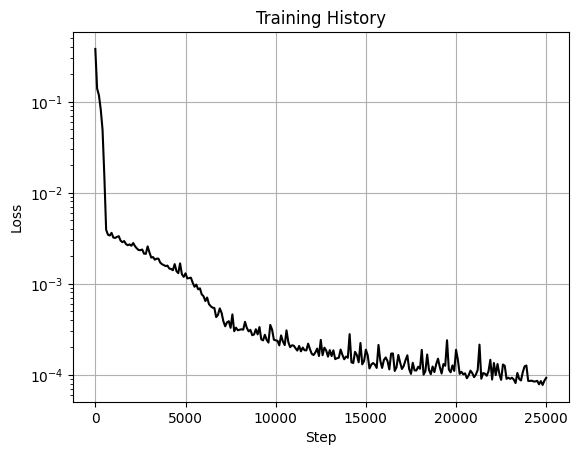

In [11]:
# Derivative fitting
node_deriv = NODEDerivative(key=mlp_key)
node_ = ODESolver(node_deriv)
node_, hist = klax.fit(
    node_,
    (ys_flat, ys_t_flat),
    batch_size=32,
    steps=25_000,
    loss_fn=derivative_loss,
    key=loader_key,
)
hist.plot()

Step: 0, Loss: 2.151e-03
Step: 100, Loss: 8.407e-04
Step: 200, Loss: 7.372e-04
Step: 300, Loss: 6.638e-04
Step: 400, Loss: 6.122e-04
Step: 500, Loss: 5.746e-04
Step: 600, Loss: 5.451e-04
Step: 700, Loss: 5.203e-04
Step: 800, Loss: 4.985e-04
Step: 900, Loss: 4.792e-04
Step: 1000, Loss: 4.620e-04
Step: 1100, Loss: 4.464e-04
Step: 1200, Loss: 4.322e-04
Step: 1300, Loss: 4.191e-04
Step: 1400, Loss: 4.069e-04
Step: 1500, Loss: 3.956e-04
Step: 1600, Loss: 3.851e-04
Step: 1700, Loss: 3.755e-04
Step: 1800, Loss: 3.664e-04
Step: 1900, Loss: 3.590e-04
Step: 2000, Loss: 3.508e-04
Step: 2100, Loss: 3.450e-04
Step: 2200, Loss: 3.370e-04
Step: 2300, Loss: 3.311e-04
Step: 2400, Loss: 3.250e-04
Step: 2500, Loss: 3.196e-04
Step: 2600, Loss: 3.145e-04
Step: 2700, Loss: 3.096e-04
Step: 2800, Loss: 3.048e-04
Step: 2900, Loss: 3.005e-04
Step: 3000, Loss: 2.963e-04
Step: 3100, Loss: 2.924e-04
Step: 3200, Loss: 2.884e-04
Step: 3300, Loss: 2.857e-04
Step: 3400, Loss: 2.822e-04
Step: 3500, Loss: 2.800e-04
Step

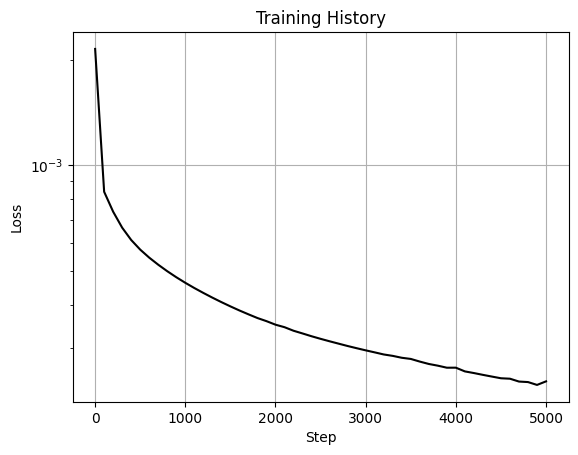

In [31]:
# Trajectory fitting

# node_deriv = NODEDerivative(key=mlp_key)
# node = ODESolver(node_deriv)

node, hist = klax.fit(
    node_,
    (ts, ys),
    batch_axis=(None, 0),
    batch_size=16,
    steps=5_000,
    loss_fn=trajectory_loss,
    optimizer=optax.adam(1e-4),
    history=klax.HistoryCallback(log_every=100),
    key=loader_key,
)
hist.plot()

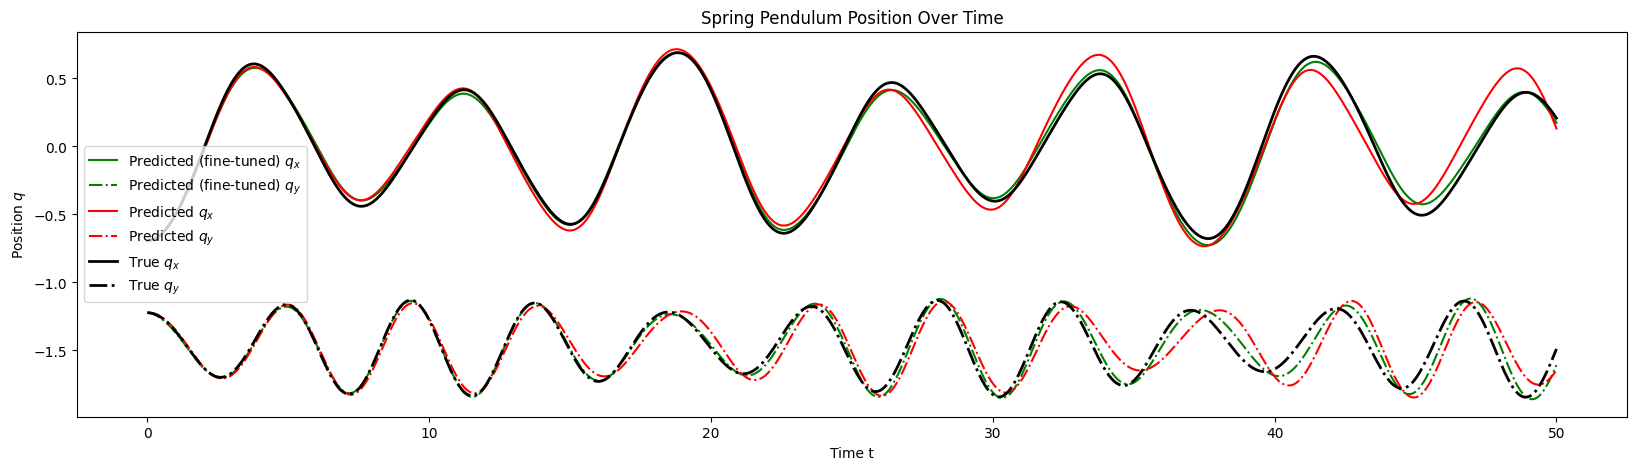

In [32]:
y0_eval = ys[0,0]#jnp.array([0.8, -0.9, 0.0, 0.0])  # Initial condition for evaluation
ts_eval = jnp.linspace(0, 50, 1000)
ys_pred = node(ts_eval, y0_eval)
ys_pred_ = node_(ts_eval, y0_eval)
ys_true = true_system(ts_eval, y0_eval)

fig, ax = plt.subplots(figsize=(20, 5))
plot_trajectory(ts_eval, ys_pred, color="green", label="Predicted (fine-tuned)")
plot_trajectory(ts_eval, ys_pred_, color="red", label="Predicted")
plot_trajectory(ts_eval, ys_true, color="black", label="True", lw=2)
plt.show()

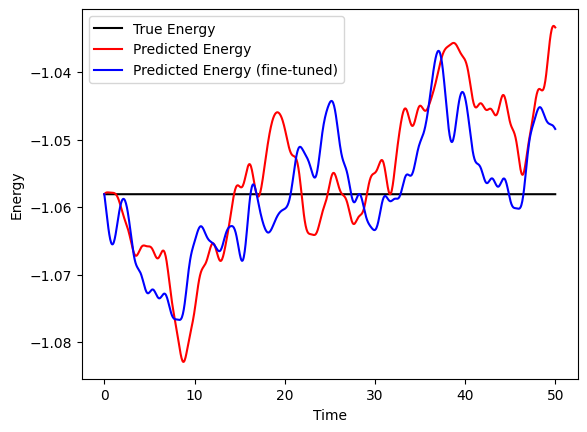

In [35]:
E_true = spring_pendulum.compute_energy(ys_true)
E_predicted_ = spring_pendulum.compute_energy(ys_pred_)
E_predicted = spring_pendulum.compute_energy(ys_pred)
plt.plot(ts_eval, E_true, label="True Energy", color="black")
plt.plot(ts_eval, E_predicted_, label="Predicted Energy", color="red")
plt.plot(ts_eval, E_predicted, label="Predicted Energy (fine-tuned)", color="blue")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [33]:
temp = jnp.stack([ys_true, ys_pred_], axis=0)
animate_spring_pendulum(ts_eval, temp, speedup=5)

## 2.2 Augemented Neural ODE
GOAL: Show that here only trajectory fitting is possible. 

Imageine we only have 1 coordinate as data.

In [39]:
ys_truncated = ys[:,:,:1]
ys_truncated.shape

(10, 500, 1)

Step: 0, Loss: 1.917e+01
Step: 100, Loss: 2.486e-01
Step: 200, Loss: 2.272e-01
Step: 300, Loss: 2.140e-01
Step: 400, Loss: 2.024e-01
Step: 500, Loss: 1.923e-01
Step: 600, Loss: 1.837e-01
Step: 700, Loss: 1.763e-01
Step: 800, Loss: 1.701e-01
Step: 900, Loss: 1.650e-01
Step: 1000, Loss: 1.607e-01
Step: 1100, Loss: 1.572e-01
Step: 1200, Loss: 1.543e-01
Step: 1300, Loss: 1.518e-01
Step: 1400, Loss: 1.497e-01
Step: 1500, Loss: 1.479e-01
Step: 1600, Loss: 1.462e-01
Step: 1700, Loss: 1.445e-01
Step: 1800, Loss: 1.427e-01
Step: 1900, Loss: 1.408e-01
Step: 2000, Loss: 1.390e-01
Step: 2100, Loss: 1.369e-01
Step: 2200, Loss: 1.351e-01
Step: 2300, Loss: 1.339e-01
Step: 2400, Loss: 1.325e-01
Step: 2500, Loss: 1.317e-01
Step: 2600, Loss: 1.308e-01
Step: 2700, Loss: 1.303e-01
Step: 2800, Loss: 1.295e-01
Step: 2900, Loss: 1.290e-01
Step: 3000, Loss: 1.285e-01
Step: 3100, Loss: 1.281e-01
Step: 3200, Loss: 1.277e-01
Step: 3300, Loss: 1.273e-01
Step: 3400, Loss: 1.270e-01
Step: 3500, Loss: 1.268e-01
Step

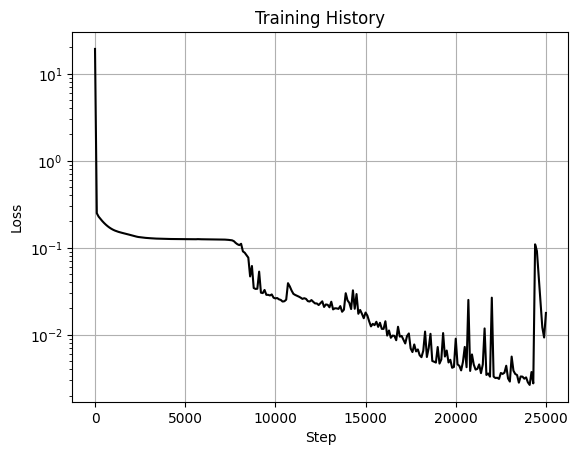

In [41]:
node_deriv = NODEDerivative(key=mlp_key)
augmented_node = ODESolver(node_deriv, augmentation=3)   # Add to augmented states to the model

augmented_node, hist = klax.fit(
    augmented_node,
    (ts, ys_truncated),
    batch_axis=(None, 0),
    steps=25_000,
    loss_fn=trajectory_loss,
    key=loader_key,
)
hist.plot()

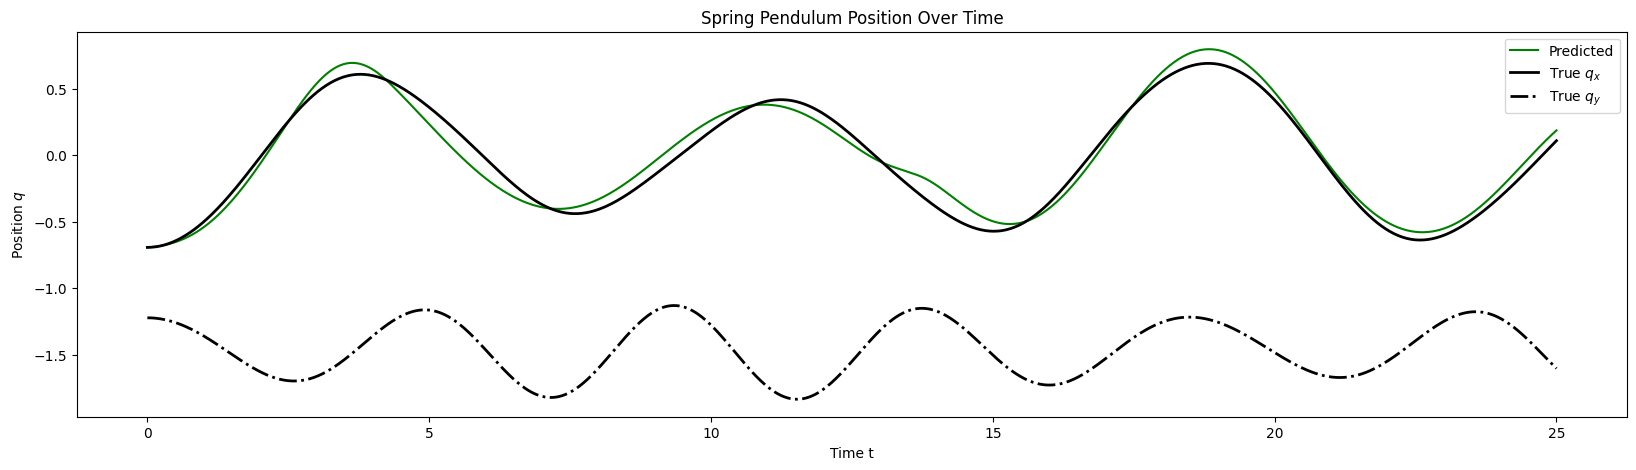

In [52]:
y0_eval = ys[0,0]#jnp.array([0.8, -0.9, 0.0, 0.0])  # Initial condition for evaluation
ts_eval = jnp.linspace(0, 25, 1000)
ys_pred = augmented_node(ts_eval, y0_eval[:1])
ys_true = true_system(ts_eval, y0_eval)

fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(ts_eval, ys_pred, color="green", label="Predicted")
plot_trajectory(ts_eval, ys_true, color="black", label="True", lw=2)
plt.show()

## 3. Energy conserving models

In [42]:
class  HamiltonianNN(eqx.Module):
    hamiltonian: klax.nn.MLP

    def __init__(self, *, key: PRNGKeyArray):

        self.hamiltonian = klax.nn.MLP(
            in_size=4,
            out_size="scalar",
            width_sizes=[32, 32],
            weight_init=jax.nn.initializers.normal(stddev=0.1),
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        grad_H = jax.grad(self.hamiltonian)(y)
        dH_dq, dH_dp = jnp.split(grad_H, 2, axis=-1)
        dq_dt = dH_dp
        dp_dt = -dH_dq
        return jnp.concatenate([dq_dt, dp_dt], axis=-1)

In [ ]:
key = jr.key(0)
model_key, loader_key = jr.split(key)

hnn_derivative = HamiltonianNN(key=model_key)
hnn = ODESolver(hnn_derivative)

hnn, hist = klax.fit(
    hnn,
    (ts, ys_truncated),
    batch_axis=(None, 0),
    steps=25_000,
    loss_fn=derivative_loss,
    key=loader_key,
)
hist.plot()